In [1]:
import mido
import heapq # merge (i.e. from mergesort)
import ripser
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import sklearn_tda as tda
import matplotlib.pyplot as plt

Gudhi not found--GraphInducedComplex not available


In [2]:
import matplotlib.colors as colors

In [3]:
mid = mido.MidiFile('data/011.mid')
msgArray = []
for i, track in enumerate(mid.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
        msgArray.append(msg)
#         print(msg)

Track 0: 
Track 1: 


In [4]:
# put together midi files 
def convertToAbsoluteTimeAndMerge(mid):
    # takes the full midi object as input
    # outputs list of pairs: [..., (abs_time, midi_message), ...]
    allEvents = []
    for i, track in enumerate(mid.tracks):
        allEvents.append([])
        abs_time = 0
        for msg in track:
            abs_time = abs_time + msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                allEvents[i].append((abs_time, msg))

    return list(heapq.merge(*allEvents, key=lambda x: x[0]))

In [5]:
# return one dimensional point cloud -> n nodes
def ExtractSingleNotesUnique(notes, getNote=lambda x: x):
    # takes the ordered set of notes as inputs. The actual note is accessed using the getNote function
    # outputs the set of notes (modulo 12) in the midi file
    noteSet = set()
    for note in notes:
        noteSet.add(getNote(note) % 12)
    return np.array(noteSet)

In [6]:
# 3D point cloud return -> note 1 note 2 note 3; note 2 note 3 note 4 -> easiest way to preserve time series. return M X N point cloud
def ExtractNotesTimeSeriesUnique(notes, N, getNote=lambda x: x):
    noteSeriesSet = set()
    for ind in range(len(notes) - N + 1):
        noteSeries = tuple(getNote(notes[ind + j]) % 12 for j in range(N))
        noteSeriesSet.add(noteSeries)
    return np.array([np.array(noteSeries) for noteSeries in noteSeriesSet])

In [7]:
# defines the distance function between every pair of points in the point cloud
def ComputeNNoteSeriesDistances(noteSeriesSet):
    dists = np.zeros((len(noteSeriesSet), len(noteSeriesSet)))
    for i in range(noteSeriesSet.shape[0]):
        for j in range(i, noteSeriesSet.shape[0]):
            v = np.abs(noteSeriesSet[i] - noteSeriesSet[j])
            diffVec = np.minimum(v, 12 - v)
            dists[i,j] = np.sum(diffVec)
            dists[j,i] = dists[i,j]
    return dists

In [7]:
mid.tracks[0][20].note

93

In [8]:
convertToAbsoluteTimeAndMerge(mid)

[(0, <message note_on channel=0 note=93 velocity=41 time=0>),
 (0, <message note_on channel=0 note=72 velocity=47 time=0>),
 (0, <message note_on channel=0 note=74 velocity=47 time=0>),
 (0, <message note_on channel=0 note=77 velocity=47 time=0>),
 (0, <message note_on channel=0 note=81 velocity=47 time=0>),
 (0, <message note_on channel=0 note=50 velocity=41 time=0>),
 (480, <message note_on channel=0 note=93 velocity=41 time=241>),
 (480, <message note_on channel=0 note=50 velocity=47 time=241>),
 (960, <message note_on channel=0 note=93 velocity=41 time=241>),
 (960, <message note_on channel=0 note=72 velocity=47 time=49>),
 (960, <message note_on channel=0 note=74 velocity=47 time=0>),
 (960, <message note_on channel=0 note=77 velocity=47 time=0>),
 (960, <message note_on channel=0 note=81 velocity=47 time=0>),
 (960, <message note_on channel=0 note=50 velocity=39 time=0>),
 (1440, <message note_on channel=0 note=93 velocity=41 time=241>),
 (1440, <message note_on channel=0 note=50

In [9]:
mid.ticks_per_beat

480

In [10]:
mid = mido.MidiFile('data/013.mid')
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 1, getNote=lambda x: x[1].note)
print(len(notes))
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)
print(len(notes))
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 3, getNote=lambda x: x[1].note)
print(len(notes))

7
41
130


In [11]:
notes.shape

(130, 3)

In [12]:
notes[0]

array([8, 6, 6])

In [13]:
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)
print(len(notes))
notes[0].shape

41


(2,)

In [14]:
dists = ComputeNNoteSeriesDistances(notes)

In [15]:
print(notes[2])
print(notes[16])

[11 11]
[5 5]


In [16]:
dgms1 = ripser.ripser(dists, distance_matrix=True, maxdim=1)['dgms']
len(dgms1)

2

In [17]:
mid = mido.MidiFile('data/001.mid')

In [18]:
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)

In [19]:
dists = ComputeNNoteSeriesDistances(notes)

In [20]:
dgms2 = ripser.ripser(dists, distance_matrix=True, maxdim=1)['dgms']

In [17]:
def getDistances():
    numFiles = 30
    dim = 3
    bottleneck_distances = [np.zeros((numFiles, numFiles)) for x in range(dim+1)]
    wassertian_distances = [np.zeros((numFiles, numFiles)) for x in range(dim+1)]
    dgmArr = [[] for x in range(dim+1)]
    
    for i in tqdm(range(1, numFiles + 1)):
        if i <= 9:
            path = "data/00" + str(i) + ".mid"
        else:
            path = "data/0" + str(i) + ".mid"
        mid = mido.MidiFile(path)
        notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)
        dists = ComputeNNoteSeriesDistances(notes)
        dgms = ripser.ripser(dists, distance_matrix=True, maxdim=dim)['dgms']
        dgmArr[0].append(dgms[0][:-1])
        for j in range(1, dim+1):
            dgmArr[j].append(dgms[j])
            
    # Computing the distances between two dgmArr and plot it with TSNE
    for i in tqdm(range(numFiles)):
        for j in (range(numFiles)):
            for k in range(dim+1):
                bottleneck_distances[k][i][j] = tda.bottleneck(dgmArr[k][i], dgmArr[k][j])
                
# Computing the distances between two dgmArr and plot it with TSNE
    for i in tqdm(range(numFiles)):
        for j in (range(numFiles)):
            for k in range(dim+1):
                wassertian_distances[k][i][j] = tda.wasserstein(dgmArr[k][i], dgmArr[k][j])
    return bottleneck_distances, wassertian_distances

In [127]:
## Compute the distances between the 0 and 1 dimensional persistence diagrams and plot it using TSNE

# Filling up the dgmArray for 0 and 1 dimension. 

numFiles = 30
dim = 3

bottleneck_distances = [np.zeros((numFiles, numFiles)) for x in range(dim+1)]
wassertian_distances = [np.zeros((numFiles, numFiles)) for x in range(dim+1)]
bottleneck_distances_dim0 = np.zeros((numFiles, numFiles))
bottleneck_distances_dim1 = np.zeros((numFiles, numFiles))
dgmArr = [[] for x in range(dim+1)]
dgmArr0 = []
dgmArr1 = []

In [128]:
for i in tqdm(range(1, numFiles + 1)):
    if i <= 9:
        path = "data/00" + str(i) + ".mid"
    else:
        path = "data/0" + str(i) + ".mid"
    mid = mido.MidiFile(path)
    notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)
    dists = ComputeNNoteSeriesDistances(notes)
    dgms = ripser.ripser(dists, distance_matrix=True, maxdim=dim)['dgms']
    dgmArr0.append(dgms[0][:-1])
    dgmArr1.append(dgms[1])   
    dgmArr[0].append(dgms[0][:-1])
    for j in range(1, dim+1):
        dgmArr[j].append(dgms[j])

In [129]:
# # Computing the distances between two dgmArr and plot it with TSNE
# for i in tqdm(range(numFiles)):
#     for j in (range(numFiles)):
#         bottleneck_distances_dim0[i][j] = tda.bottleneck(dgmArr0[i], dgmArr0[j])
#         bottleneck_distances_dim1[i][j] = tda.bottleneck(dgmArr1[i], dgmArr1[j])

In [130]:
# Computing the distances between two dgmArr and plot it with TSNE
for i in tqdm(range(numFiles)):
    for j in (range(numFiles)):
        for k in range(dim+1):
            bottleneck_distances[k][i][j] = tda.bottleneck(dgmArr[k][i], dgmArr[k][j])

In [131]:
# Computing the distances between two dgmArr and plot it with TSNE
for i in tqdm(range(numFiles)):
    for j in (range(numFiles)):
        for k in range(dim+1):
            wassertian_distances[k][i][j] = tda.wasserstein(dgmArr[k][i], dgmArr[k][j])

In [24]:
def computeDimReduction(method, distances, numFiles):
    distances = (distances + distances.T)/2
    distances_transformed = np.empty(shape=(numFiles, 2))
    if method == 'MDS':
        distances_transformed = MDS(n_components=2, dissimilarity='precomputed').fit_transform(distances)
    elif method == 'TSNE':
        distances_transformed = TSNE(n_components=2, metric='precomputed').fit_transform(distances)
    return distances_transformed

In [25]:
def plotScatter(distances, measure, numFiles):
    bd_x = np.zeros(len(distances))
    bd_y = np.zeros(len(distances))

    for i in range(len(distances)):
        bd_x[i] = distances[i][0]
        bd_y[i] = distances[i][1]

    labelArray = np.zeros(numFiles)
    ## LabelArray contains the labels for each of the image. 
    label = 0
    for i in range(len(labelArray)):
        if i >= 10 and i <= 24:
            label = 1
        elif i >= 25:
            label = 2
        labelArray[i] = label
    classes = ("Artist1", "Artist2", "Artist3")
    
    # Define a colormap with the right number of colors
    cmap = plt.cm.get_cmap('tab10',max(labelArray)-min(labelArray)+1)
    bounds = range(int(min(labelArray)),int(max(labelArray))+2)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    plt.scatter(bd_x, bd_y, c = labelArray, cmap = cmap, norm = norm)
    cb=plt.colorbar(ticks=np.array(labelArray)+0.5)
    cb.set_ticklabels(labelArray)
    plt.title(measure)
    plt.show()

In [20]:
bottleneck_distances, wassertian_distances = getDistances()

0


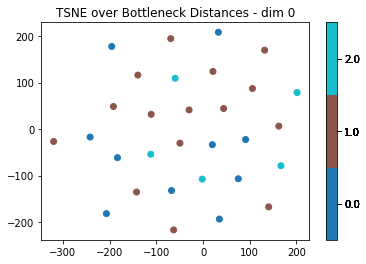

1


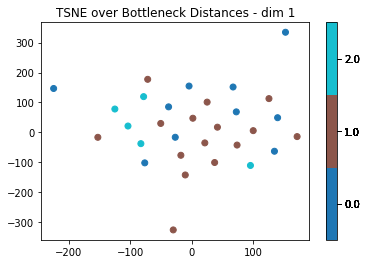

2


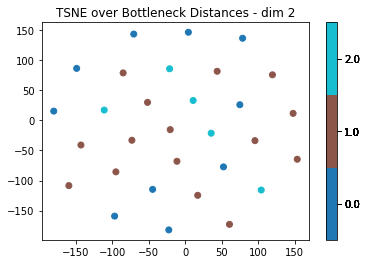

3


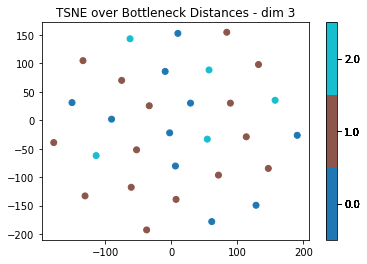

In [26]:
dim = 3
numFiles = 30
for j in range(dim+1):
    print(j)
    bottleneck_distances_TSNE = computeDimReduction('TSNE', bottleneck_distances[j], numFiles)
    label = "TSNE over Bottleneck Distances - dim " + str(j)
    plotScatter(bottleneck_distances_TSNE, label, numFiles)

0


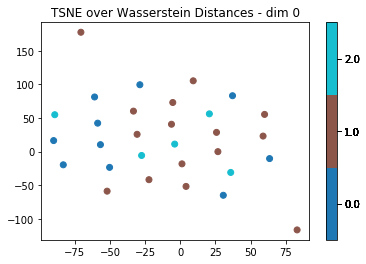

1


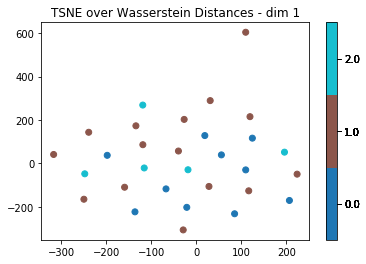

2


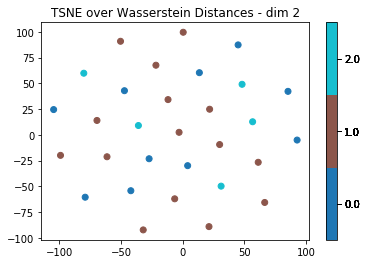

3


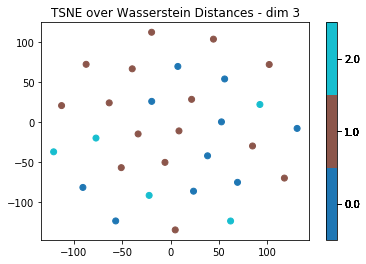

In [27]:
dim = 3
numFiles = 30
for j in range(dim+1):
    print(j)
    wassertian_distances_TSNE = computeDimReduction('TSNE', wassertian_distances[j], numFiles)
    label = "TSNE over Wasserstein Distances - dim " + str(j)
    plotScatter(wassertian_distances_TSNE, label, numFiles)